<a href="https://colab.research.google.com/github/MafikengZ/NLP-Tweet-Sentiment-Ananlysis/blob/main/Sello_model_v0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Tweet Sentiment Analysis

## Comet Configurations

In [ ]:
!pip install comet_ml
!pip install tweet-preprocessor
!pip install nlppreprocess

In [ ]:
# import comet_ml
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="HfSNpkY9koDD8GCccjV6a7o3K",
    project_name="nlp-tweet-sentiment-analysis",
    workspace="mafikengz",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mafikengz/nlp-tweet-sentiment-analysis/dd35bdae1b4241fcbf72756611f09c3d



## Import Standard Libraries

In [ ]:
#Regex string manipulation library
import re
import string

#Data preprocessing libraries
import numpy as np
import pandas as pd
import preprocessor as p

#Data Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
# from jupyterthemes import jtplot
%matplotlib inline

#NLP libraries
import tweepy
from textblob import TextBlob
import nltk

# sklearn libraries
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer , TfidfTransformer
from sklearn.metrics import accuracy_score , classification_report, confusion_matrix

In [ ]:
# configurations
pd.set_option('display.max_colwidth', 100)
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
# jtplot.style(theme='monokai' , context='notebook' , ticks=True , grid=False)

#Warning filter
import warnings
warnings.filterwarnings("ignore")

#NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load Dataset

In [ ]:
df_train = pd.read_csv('sample_data/train.csv' , encoding='UTF-8')
df_test = pd.read_csv('sample_data/test_with_no_labels.csv' , encoding='UTF-8')

In [ ]:
#Create a copy of tweetid column
copy_df_test = df_test.tweetid.values.copy()

#Drop tweetid column
df_train.drop(['tweetid'], axis=1, inplace=True)
df_test.drop(['tweetid'], axis=1, inplace=True)

   ***Drop tweetid column:***

- 
    Represents an id for each uniques tweet
    therefore all tweets in our dataset are unique,
- Hence they have a value count of 1
- Tweetid however does not add value to our model

### Data Exploration (EDA)

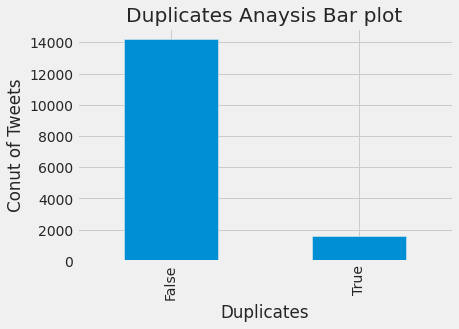

In [ ]:
duplicated = df_train.message.duplicated().value_counts()
#Create Bar plot
duplicated.plot(kind='bar')
plt.title('Duplicates Anaysis Bar plot')
plt.xlabel('Duplicates')
plt.ylabel('Conut of Tweets')
plt.show()


In [ ]:
#Remove Duplicates
# df_train.drop_duplicates(subset='message', keep='last', inplace=True)

<AxesSubplot:>

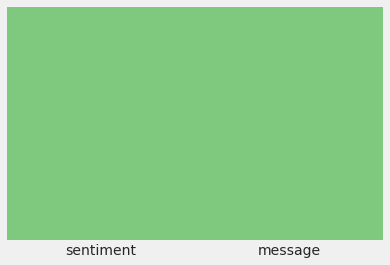

In [ ]:
#Check for null values 
sns.heatmap(df_train.isna(), yticklabels=False , cbar=False , cmap='Accent')

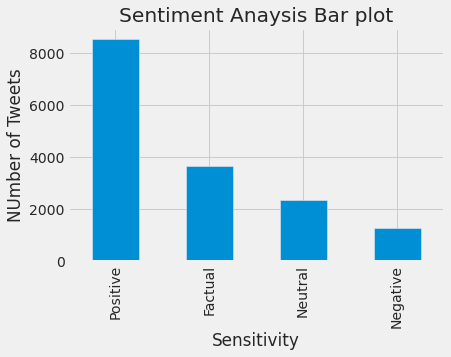

In [ ]:
#Asses sentiment column
def _get_sentiment(score):
    if score == -1:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score == 1:
        return 'Positive'
    elif score == 2:
        return 'Factual'

sens = df_train['sentiment'].apply(_get_sentiment)
#Create Bar plot
sens.value_counts().plot(kind='bar')
plt.title('Sentiment Anaysis Bar plot')
plt.xlabel('Sensitivity')
plt.ylabel('NUmber of Tweets')
plt.show()

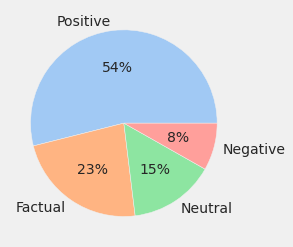

In [ ]:
data = [round((df_train.sentiment == 1).sum() / df_train.shape[0] *100,2),
        round((df_train.sentiment == 2).sum() / df_train.shape[0] *100,2),
        round((df_train.sentiment == 0).sum() / df_train.shape[0] *100,2),
        round((df_train.sentiment == -1).sum() / df_train.shape[0] *100,2)]

labels = ['Positive' , 'Factual' , 'Neutral', 'Negative']
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
from collections import Counter

In [ ]:
counter = Counter(df_train['sentiment'])
for k ,v in counter.items():
    dist = v / len(df_train['sentiment']) * 100
    print(f'Class: {k}  N: {v}  Dist: {round(dist,2)}')


Class: 1  N: 8530  Dist: 53.92
Class: 2  N: 3640  Dist: 23.01
Class: 0  N: 2353  Dist: 14.87
Class: -1  N: 1296  Dist: 8.19


<BarContainer object of 4 artists>

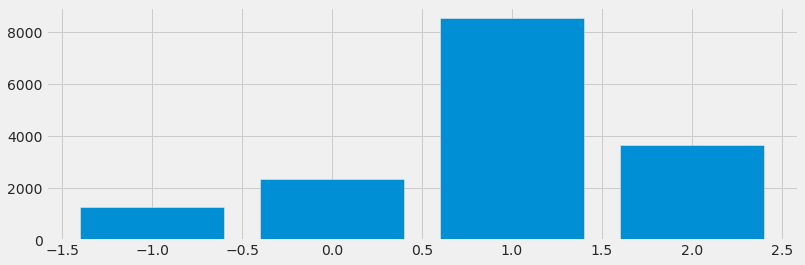

In [ ]:
plt.figure(1 , figsize=(12,4))
plt.bar(counter.keys() , counter.values())

In [ ]:
# import numpy as np
# plt.figure(1 , figsize=(20,10))
# for label ,_ in counter.items():
#     row = np.where(df_train['sentiment'] == label)[0]
#     plt.scatter(df_train['message'][row ,0] , df_train['message'][row ,1]  , label=str(label))
# plt.legend()

**Imbalance Dataset**

**Slight Imbalance:** An imbalanced classification problem where the distribution of examples is uneven by a small amount in the training dataset (e.g. 4:6).


- Positive (1): Above 8000 Tweets which are positvive **54%**
- Factual news (2): Below 4000 Tweets are factual **23%**
- Negative (-1): Below 2000 Tweets are negative **8%**
- Neutral (0): Slightly above 2000 **15%**

In [ ]:
#Assess the length of tweets
df_train['length'] = df_train['message'].apply(lambda x: len(x))

### Data Preprocessing

In [ ]:
#Clean data using tweet preprocessor
def _clean_tweet(data):
    """
    Function clean dataset removing URLs
    Hashtags
    Mentions
    Reserved words (RT, FAV)
    Emojis
    Smileys
    
    Args:
        data: pandas dataframe
    Return:
        Dataframe: clean tweets
    """
    return p.clean(data)
#Apply the function to the dataset
df_train['clean_tweets'] = df_train['message'].apply(_clean_tweet)

In [ ]:
#Remove punctuations
def _remove_punc(data):
    """
    Func removes punctuation and ASCII character
    using string.punctuation function
    
    Args:
        data: pandas dataframe
    Return:
        Dataframe: clean tweets
    """
    data = re.sub('\\n' , '' , data) #Remove any new lines
    data  = "".join([char for char in data if char not in string.punctuation]) #Remove punctuations
    data = re.sub(r'[^\x00-\x7f]',r'', data)
    return data
#Apply the function to the dataset
df_train['cleaned'] = df_train['clean_tweets'].apply(_remove_punc)

In [ ]:
def _lower(data):
    return data.lower()
df_train['lower'] = df_train['cleaned'].apply(_lower)

In [ ]:
# def _remove_numbers(data):
#     data = re.sub('[0-9]+', '', data)
#     return data
# df_train['number'] = df_train['lower'].apply(_remove_numbers)

In [ ]:
from nlppreprocess import NLP
nlp = NLP()
nlp.process('couldnt')

'could not'

In [ ]:
#Remove Stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(data):
    """
    Remove stop-word in the dataset to reduce noise
    Args:
        Args:
        data: pandas dataframe
    Return:
        Dataframe:non-stop word
    """
    stopwords = NLP(replace_words=True, remove_stopwords=True, 
                            remove_numbers=True, remove_punctuations=False) 
    data = stopwords.process(data)
    return data
    
df_train['Tweet_nonstop'] = df_train['lower'].apply(lambda x: remove_stopwords(x))
df_train.head()

,sentiment,message,clean_tweets,cleaned,lower,Tweet_nonstop
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, ...","PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, ...",PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what...,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what...,polyscimajor epa chief not think carbon dioxide main cause global warming and wait what via
1,1,It's not like we lack evidence of anthropogenic global warming,It's not like we lack evidence of anthropogenic global warming,Its not like we lack evidence of anthropogenic global warming,its not like we lack evidence of anthropogenic global warming,its not like we lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late ...,: Researchers say we have three years to act on climate change before its too late,Researchers say we have three years to act on climate change before its too late,researchers say we have three years to act on climate change before its too late,researchers say we three years act climate change before its too late
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,WIRED : was a pivotal year in the war on climate change,WIRED was a pivotal year in the war on climate change,wired was a pivotal year in the war on climate change,wired pivotal year in war climate change
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in...",": It's , and a racist, sexist, climate change denying bigot is leading in the polls.",Its and a racist sexist climate change denying bigot is leading in the polls,its and a racist sexist climate change denying bigot is leading in the polls,its and racist sexist climate change denying bigot leading in polls


In [ ]:
#Tokenization
def tokenization(data):
    data = re.split('\W+', data)
    return data

df_train['Tweet_tokenized'] = df_train['Tweet_nonstop'].apply(lambda x: tokenization(x))
df_train.head()

,sentiment,message,clean_tweets,cleaned,lower,Tweet_nonstop,Tweet_tokenized
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, ...","PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, ...",PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what...,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what...,polyscimajor epa chief not think carbon dioxide main cause global warming and wait what via,"[polyscimajor, epa, chief, not, think, carbon, dioxide, main, cause, global, warming, and, wait,..."
1,1,It's not like we lack evidence of anthropogenic global warming,It's not like we lack evidence of anthropogenic global warming,Its not like we lack evidence of anthropogenic global warming,its not like we lack evidence of anthropogenic global warming,its not like we lack evidence anthropogenic global warming,"[its, not, like, we, lack, evidence, anthropogenic, global, warming]"
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late ...,: Researchers say we have three years to act on climate change before its too late,Researchers say we have three years to act on climate change before its too late,researchers say we have three years to act on climate change before its too late,researchers say we three years act climate change before its too late,"[researchers, say, we, three, years, act, climate, change, before, its, too, late]"
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,WIRED : was a pivotal year in the war on climate change,WIRED was a pivotal year in the war on climate change,wired was a pivotal year in the war on climate change,wired pivotal year in war climate change,"[wired, pivotal, year, in, war, climate, change]"
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in...",": It's , and a racist, sexist, climate change denying bigot is leading in the polls.",Its and a racist sexist climate change denying bigot is leading in the polls,its and a racist sexist climate change denying bigot is leading in the polls,its and racist sexist climate change denying bigot leading in polls,"[its, and, racist, sexist, climate, change, denying, bigot, leading, in, polls]"


In [ ]:
# Lemmitization
lem = nltk.WordNetLemmatizer()

def lemmatizer(data):
    data = [lem.lemmatize(word) for word in data]
    return ' '.join(data)

df_train['lemmatized'] = df_train['Tweet_tokenized'].apply(lambda x: lemmatizer(x))

In [ ]:
# #Stemming
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english")
# def stemming(data):
#     data = " ".join([stemmer.stem(word) for word in data])
#     return data

# df_train['Tweet_stemmed'] = df_train['Tweet_lemmatized'].apply(lambda x: stemming(x))
# df_train.head()

In [ ]:
#Assess the length of tweets
df_train['after_length'] = df_train['Tweet_lemmatized'].apply(lambda x: len(x))
df_train.head()

KeyError: ignored

In [ ]:
df_train.shape

(15819, 9)

In [ ]:
def _analyzer (data):
    """
    Function 
    """
    data  = _clean_tweet(data)
    data = _remove_punc(data)
    data = _lower(data)
    # data = _remove_numbers(data)
    data = remove_stopwords(data)
    data = tokenization(data)
    data = lemmatizer(data)
    # data = stemming(data)
    return data

### Feature Extraction 

#### Train Test Split

#### Apply Logistic Regression 

In [ ]:
# from nltk.tokenize import word_tokenize
# log_reg = Pipeline([('vect' , CountVectorizer(analyzer=_analyzer)),
#                     ('tfid' , TfidfVectorizer()),
#                     ('clf' , LogisticRegression(multi_class='ovr'))])

# log_reg.fit(X_train.values.ravel(), y_train.values.ravel())
# log_pred = log_reg.predict(X_test.values.ravel())
countVector = TfidfVectorizer(ngram_range=(1, 2), analyzer='word')
countVectorized = countVector.fit_transform(df_train['message'].apply(_analyzer)).toarray()


In [ ]:
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
#Scaler
scale = MaxAbsScaler().fit(countVectorized)
transform = scale.transform(countVectorized)

In [ ]:
X = transform
y = df_train.sentiment

#### Data Resampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
oversample= SMOTE()
undersample = RandomUnderSampler()

steps = [('o' , oversample),
      ('u' , undersample)]
pipeline = Pipeline(steps=steps)
X , y = pipeline.fit_resample(X , y)

In [ ]:
# use 70% for the training and 30% for the test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42, test_size=0.3)

In [ ]:
X_train

array([[0.75334056, 0.54628382, 0.09846815, ..., 0.        , 0.13319222,
        0.        ],
       [0.84833736, 0.48680668, 0.16922991, ..., 0.        , 0.40691645,
        0.        ],
       [0.84868943, 0.42286415, 0.0438784 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.85326035, 0.3046912 , 0.18894372, ..., 0.        , 0.2496141 ,
        0.        ],
       [0.6864696 , 0.3882781 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.83909694, 0.30761536, 0.23763405, ..., 0.        , 0.10714465,
        0.        ]])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [ ]:
# Creating a list of all the models to train
algs = [LogisticRegression(multi_class='ovr'),RandomForestClassifier()]

In [ ]:
# Fitting models onto the training data and predicting.
for i in range(0, len(algs)):
    text_clf = Pipeline([
                         ('clf', algs[i])])
    text_clf.fit(X_train, y_train)  
    predictions = text_clf.predict(X_test)

    print(algs[i])
    print(metrics.confusion_matrix(y_test,predictions))
    print(metrics.classification_report(y_test,predictions))
    print('F1_score: ',round(metrics.f1_score(y_test,predictions, average = 'weighted'),3))
    print('-------------------------------------------------------')

LogisticRegression(multi_class='ovr')
[[1050  395  553  578]
 [ 641  803  626  512]
 [ 469  335  954  700]
 [ 361  197  440 1622]]
              precision    recall  f1-score   support

          -1       0.42      0.41      0.41      2576
           0       0.46      0.31      0.37      2582
           1       0.37      0.39      0.38      2458
           2       0.48      0.62      0.54      2620

    accuracy                           0.43     10236
   macro avg       0.43      0.43      0.43     10236
weighted avg       0.43      0.43      0.43     10236

F1_score:  0.426
-------------------------------------------------------
RandomForestClassifier()
[[2379   47   76   74]
 [  83 2178  186  135]
 [ 144  243 1714  357]
 [  76   67  300 2177]]
              precision    recall  f1-score   support

          -1       0.89      0.92      0.90      2576
           0       0.86      0.84      0.85      2582
           1       0.75      0.70      0.72      2458
           2       0.79   

In [ ]:
# print('Classification Report: LogisticRegression()') 
# print(classification_report(y_test, log_pred))
# print('Accuracy Score: {}'.format(round(accuracy_score(y_test, log_pred) * 100,2)))
